# Text mining & Search Project

### Università degli Studi di Milano-Bicocca  2020/2021

**Luzzi Federico** 816753 **Peracchi Marco** 800578

# Text Classification

In this notebook it's possible to visualize text classification applyed by using different machine learning classifiers.

In [1]:
import os
import pandas as pd
import numpy as np
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [3]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [4]:
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers 

In [5]:
# confusion matrix plot
def c_matrix(y_val, y_pred, classes):
    cm = confusion_matrix(y_val, y_pred)
    fig, ax= plt.subplots(figsize = (8,6))
    sns.heatmap(cm, annot=True, annot_kws={"size": 10},
              linewidths=.2, fmt="d", cmap="PuBu")
    plt.xlabel("Predicted Class", size = 12, horizontalalignment="right")
    plt.ylabel("True Class", size = 12)
    ax.set_yticklabels(classes, rotation = 45, fontdict= {'fontsize': 10})
    ax.set_xticklabels(classes, rotation = 30, fontdict= {'fontsize': 10})
    plt.title("Confusion matrix", size = 20)
    plt.show()

In [49]:
# loss plot of neural network
def loss_plotter(history):
    fig = plt.figure(figsize=(6,8))
    plt.subplot(2, 1, 1)
    plt.plot(history.history["loss"], label = "Train loss",
             color = "forestgreen")
    plt.plot(history.history["val_loss"], label= "Validation loss",
             color = "orange")
    plt.legend(loc='upper right', fontsize = 10)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Value', size = 15)
    plt.title("Loss function", size =20)
    plt.show()
    fig = plt.figure(figsize=(6,8))
    plt.subplot(2, 1, 2)
    plt.plot(history.history["acc"], label = "Train accuracy",
             color = "forestgreen")
    plt.plot(history.history["val_acc"], label= "Validation accuracy",
             color = "orange")
    plt.legend(fontsize = 12)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Value', size = 15)
    plt.title("Accuracy function", size =20)
    plt.show()

In [6]:
if 'featured_data.csv' not in os.listdir('data'):
    print("!!! ERROR !!!\n --- Before this, execute 03-Features_extraction Notebook ---")
else:
    df = pd.read_csv("data/featured_data.csv", sep = ",")
    print("Features loaded --- DONE")

Features loaded --- DONE


### Load Tf-idf Vectorization

In [8]:
tfidf = np.load("data/representations/tf-idf.npy")

In [9]:
tfidf.shape

(24781, 4000)

## Feature extraction and splitting data

In [10]:
df["class"].value_counts()

1    19189
2     4162
0     1430
Name: class, dtype: int64

In [11]:
df["class_bin"] = 0
df.loc[df["class"] <= 1, "class_bin"] = 1

In [12]:
df["class_bin"].value_counts()

1    20619
0     4162
Name: class_bin, dtype: int64

0 --> Not hate or offensive

1 --> Hate or offensive

In [13]:
X_data = tfidf
Y_data = df["class_bin"]

# verifica dimensioni vettori
assert X_data.shape[0] == Y_data.shape[0]

In [14]:
# class weights
# w_J = n_samples / (n_classes * n_samples_J)
weights = len(df['class_bin']) / (2 * df['class_bin'].value_counts())

# split train-test
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data,
                                                   test_size = 0.2,
                                                   random_state = 42,
                                                   shuffle = True,
                                                   stratify = Y_data)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

### Class weights
Computing class weights as follows

$w_j = \frac{num\_samples}{num\_classes \cdot num\_samples_j}$

## Models with performances

### Support Vector Machine

In [15]:
# model
model = SVC(random_state = 42, 
            class_weight= {0 : weights[0], 1 : weights[1]})

In [16]:
%%time
# fitting
model.fit(X_train, y_train)
print("Modelling --- DONE")

Modelling --- DONE
Wall time: 14min 19s


In [17]:
# save model
filename = 'svm.sav'
pickle.dump(model, open(f'models/binary/{filename}', 'wb'))

In [18]:
# load model
filename = 'svm.sav'
model = pickle.load(open(f'models/binary/{filename}', 'rb'))

Performance on TRAIN:
Classification report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3329
           1       1.00      0.98      0.99     16495

    accuracy                           0.98     19824
   macro avg       0.95      0.99      0.97     19824
weighted avg       0.98      0.98      0.98     19824



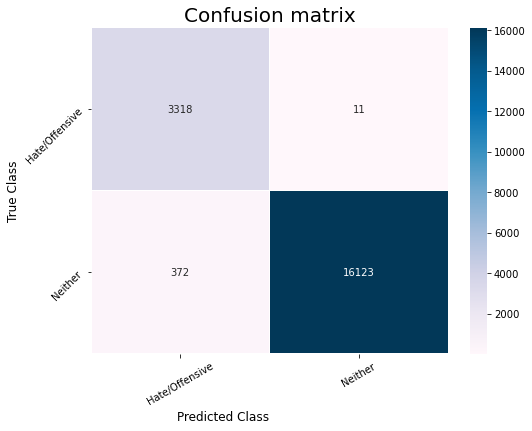

Wall time: 9min 38s


In [17]:
%%time
# performance on TRAIN
print("Performance on TRAIN:")
y_pred = model.predict(X_train)   
print('Classification report:')
print(classification_report(y_train, y_pred))
c_matrix(y_train, y_pred, ["Neither", "Hate/Offensive"])

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       833
           1       0.99      0.96      0.97      4124

    accuracy                           0.96      4957
   macro avg       0.91      0.95      0.93      4957
weighted avg       0.96      0.96      0.96      4957



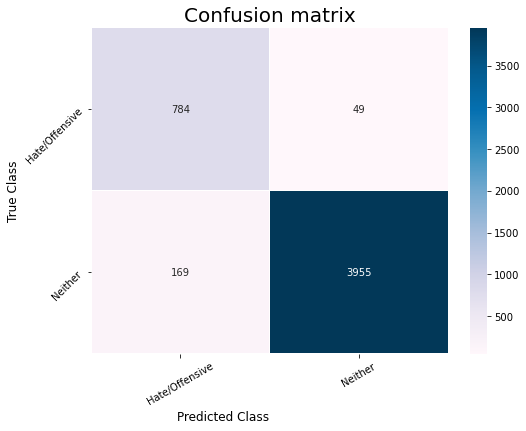

Wall time: 2min 25s


In [18]:
%%time
# performance on TEST
y_pred = model.predict(X_test)   
print('Classification report:')
print(classification_report(y_test, y_pred))
c_matrix(y_test, y_pred, ["Neither", "Hate/Offensive"]) 

### Adaboost

In [14]:
adaboost = AdaBoostClassifier(n_estimators=50, random_state=0)

In [15]:
adaboost.fit(X_train, y_train)

AdaBoostClassifier(random_state=0)

In [16]:
# save model
filename = 'adaboost.sav'
pickle.dump(model, open(f'models/binary/{filename}', 'wb'))

NameError: name 'model' is not defined

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3329
           1       0.99      0.96      0.97     16495

    accuracy                           0.96     19824
   macro avg       0.91      0.95      0.93     19824
weighted avg       0.96      0.96      0.96     19824



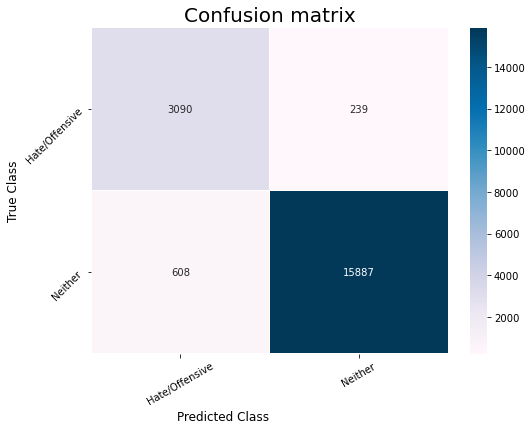

Wall time: 17.2 s


In [17]:
%%time
# performance on TRAIN
y_pred = adaboost.predict(X_train)   
print('Classification report:')
print(classification_report(y_train, y_pred))
c_matrix(y_train, y_pred, ["Neither", "Hate/Offensive"]) 

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       833
           1       0.98      0.96      0.97      4124

    accuracy                           0.96      4957
   macro avg       0.91      0.95      0.93      4957
weighted avg       0.96      0.96      0.96      4957



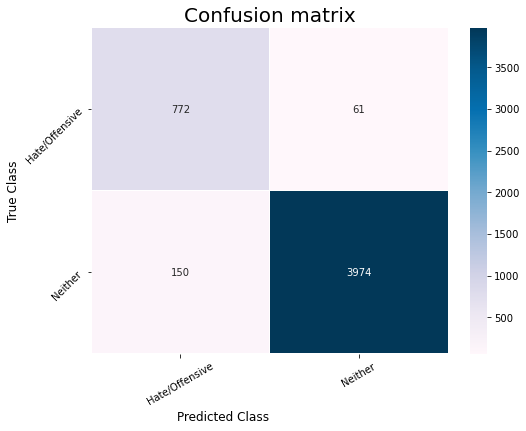

Wall time: 4.57 s


In [18]:
%%time
# performance on TEST
y_pred = adaboost.predict(X_test)   
print('Classification report:')
print(classification_report(y_test, y_pred))
c_matrix(y_test, y_pred, ["Neither", "Hate/Offensive"]) 

### Logistic Regression

In [19]:
model = LogisticRegression(random_state = 42, max_iter = 1000,
            class_weight= {0 : weights[0], 1 : weights[1]})

In [20]:
%%time
# fitting
model.fit(X_train, y_train)
print("Modelling --- DONE")

Modelling --- DONE
Wall time: 4.97 s


In [21]:
# save model
filename = 'logistic.sav'
pickle.dump(model, open(f'models/binary/{filename}', 'wb'))

Performance on TRAIN:
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      3329
           1       1.00      0.94      0.97     16495

    accuracy                           0.95     19824
   macro avg       0.89      0.96      0.92     19824
weighted avg       0.96      0.95      0.95     19824



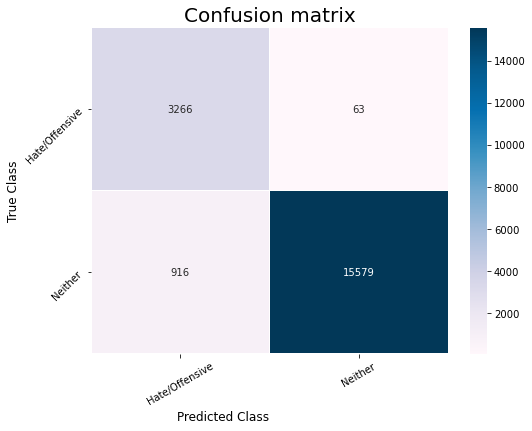

Wall time: 487 ms


In [22]:
%%time
# performance on TRAIN
print("Performance on TRAIN:")
y_pred = model.predict(X_train)   
print('Classification report:')
print(classification_report(y_train, y_pred))
c_matrix(y_train, y_pred, ["Neither", "Hate/Offensive"])

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.96      0.86       833
           1       0.99      0.94      0.97      4124

    accuracy                           0.95      4957
   macro avg       0.88      0.95      0.91      4957
weighted avg       0.96      0.95      0.95      4957



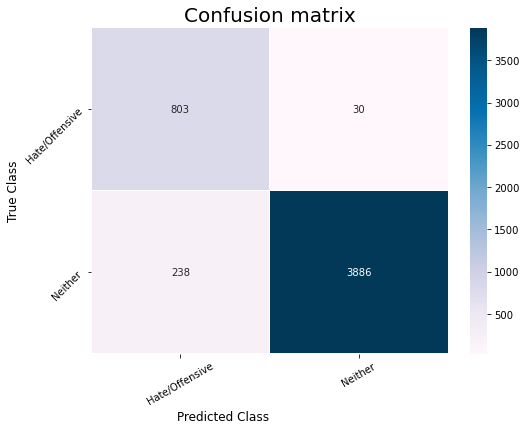

Wall time: 358 ms


In [23]:
%%time
# performance on TEST
y_pred = model.predict(X_test)   
print('Classification report:')
print(classification_report(y_test, y_pred))
c_matrix(y_test, y_pred, ["Neither", "Hate/Offensive"]) 

### Random Forest

In [24]:
model = RandomForestClassifier(random_state = 42,
            class_weight= {0 : weights[0], 1 : weights[1]})

In [25]:
%%time
# fitting
model.fit(X_train, y_train)
print("Modelling --- DONE")

Modelling --- DONE
Wall time: 1min 59s


In [33]:
# save model
filename = 'random_forest.sav'
pickle.dump(model, open(f'models/binary/{filename}', 'wb'))

Performance on TRAIN:
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3329
           1       1.00      1.00      1.00     16495

    accuracy                           1.00     19824
   macro avg       1.00      1.00      1.00     19824
weighted avg       1.00      1.00      1.00     19824



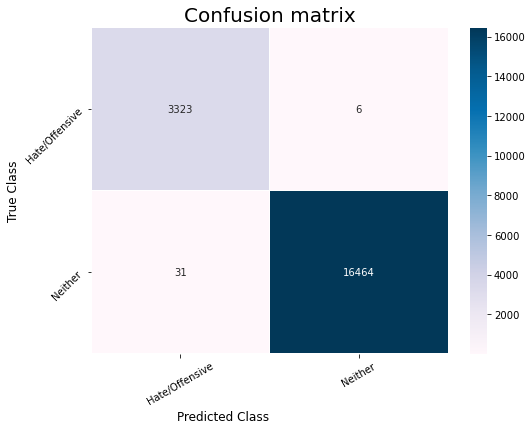

Wall time: 2.85 s


In [26]:
%%time
# performance on TRAIN
print("Performance on TRAIN:")
y_pred = model.predict(X_train)   
print('Classification report:')
print(classification_report(y_train, y_pred))
c_matrix(y_train, y_pred, ["Neither", "Hate/Offensive"])

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       833
           1       0.98      0.97      0.98      4124

    accuracy                           0.96      4957
   macro avg       0.92      0.94      0.93      4957
weighted avg       0.96      0.96      0.96      4957



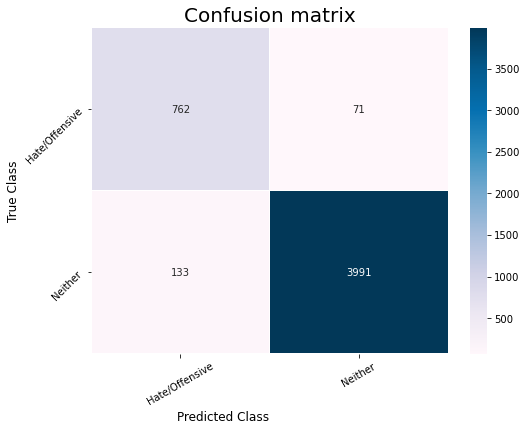

Wall time: 979 ms


In [27]:
%%time
# performance on TEST
y_pred = model.predict(X_test)   
print('Classification report:')
print(classification_report(y_test, y_pred))
c_matrix(y_test, y_pred, ["Neither", "Hate/Offensive"]) 

### Neural Network

In [28]:
Y_data_bin = keras.utils.to_categorical(Y_data)

X_train, X_test, y_train_bin, y_test_bin = train_test_split(X_data, Y_data_bin,
                                                   test_size = 0.2,
                                                   random_state = 42,
                                                   shuffle = True,
                                                   stratify = Y_data)

In [29]:
def neural_network(dims, seed):
    model = Sequential()
    model.add(Dense(64, input_shape = (dims,), 
                    activation = 'relu',
                    kernel_regularizer = regularizers.l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax',
                    kernel_regularizer = regularizers.l2(1e-4)))

    model.compile(loss = 'categorical_crossentropy',
                 optimizer = keras.optimizers.Adam(lr=0.0001),
                 metrics=['acc'])
    return model

def neural_network_2(dims, seed):
    model = Sequential()
    model.add(Dense(128, input_shape = (dims,), 
                    activation = 'relu', 
                    kernel_regularizer = regularizers.l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(64, input_shape = (dims,), 
                    activation = 'relu',
                    kernel_regularizer = regularizers.l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax', 
                    kernel_regularizer = regularizers.l2(1e-4)))

    model.compile(loss = 'categorical_crossentropy',
                 optimizer = keras.optimizers.Adam(lr=0.0001),
                 metrics=['acc'])
    return model

def neural_network_3(dims, seed):
    model = Sequential()
    model.add(Dense(1024, input_shape = (dims,), 
                    activation = 'relu', 
                    kernel_regularizer = regularizers.l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(256, input_shape = (dims,), 
                    activation = 'relu', 
                    kernel_regularizer = regularizers.l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(128, input_shape = (dims,), 
                    activation = 'relu', 
                    kernel_regularizer = regularizers.l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(64, input_shape = (dims,), 
                    activation = 'relu',
                    kernel_regularizer = regularizers.l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax', 
                    kernel_regularizer = regularizers.l2(1e-4)))

    model.compile(loss = 'categorical_crossentropy',
                 optimizer = keras.optimizers.Adam(lr=0.0001),
                 metrics=['acc'])
    return model

In [30]:
def checkpoint(checkpoint_filepath):
    model_checkpoint = keras.callbacks.ModelCheckpoint(
                    filepath=checkpoint_filepath,
                    save_weights_only=True,
                    monitor='val_loss',
                    mode='auto',
                    save_best_only=True)
    return model_checkpoint

In [47]:
dims = X_data.shape[1]
seed = 42
batch_s = 32
epochs_n = 20

model = neural_network_3(dims, seed)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1024)              4097024   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)               

In [48]:
%%time
history = model.fit(X_train, y_train_bin, 
                    batch_size=batch_s, 
                    epochs=epochs_n, 
                    verbose=1,
                    validation_split = 0.2,
                    class_weight = {0 : weights[0], 1 : weights[1]},
                    callbacks = [checkpoint("models/binary/nn_3.h5")])

Epoch 1/20
496/496 [==============================] - 51s 102ms/step - loss: 0.7917 - acc: 0.7359 - val_loss: 0.4435 - val_acc: 0.9253
Epoch 2/20
496/496 [==============================] - 47s 95ms/step - loss: 0.3397 - acc: 0.9287 - val_loss: 0.2845 - val_acc: 0.9405
Epoch 3/20
496/496 [==============================] - 47s 96ms/step - loss: 0.2472 - acc: 0.9591 - val_loss: 0.2653 - val_acc: 0.9468
Epoch 4/20
496/496 [==============================] - 47s 95ms/step - loss: 0.2095 - acc: 0.9672 - val_loss: 0.2602 - val_acc: 0.9501
Epoch 5/20
496/496 [==============================] - 47s 94ms/step - loss: 0.1851 - acc: 0.9739 - val_loss: 0.2641 - val_acc: 0.9468
Epoch 6/20
496/496 [==============================] - 47s 95ms/step - loss: 0.1583 - acc: 0.9800 - val_loss: 0.3017 - val_acc: 0.9407
Epoch 7/20
496/496 [==============================] - 51s 102ms/step - loss: 0.1418 - acc: 0.9839 - val_loss: 0.2802 - val_acc: 0.9460
Epoch 8/20
496/496 [==============================] - 54s 10

In [41]:
# load model 1
filename = 'nn_1.h5'
model = neural_network(dims,seed)
model.load_weights(f'models/binary/{filename}')

OSError: Unable to open file (unable to open file: name = 'models/binary/nn_2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [43]:
# load model 2
filename = 'nn_2.h5'
model = neural_network_2(dims,seed)
model.load_weights(f'models/binary/{filename}')

In [50]:
# load model 3
filename = 'nn_3.h5'
model = neural_network_3(dims,seed)
model.load_weights(f'models/binary/{filename}')

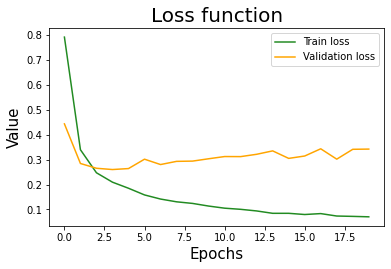

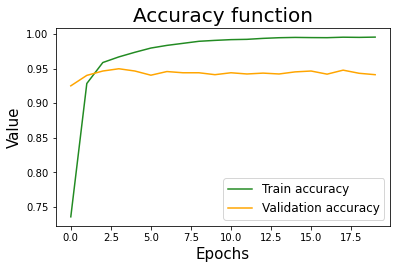

In [51]:
loss_plotter(history)

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      3329
           1       1.00      0.97      0.98     16495

    accuracy                           0.97     19824
   macro avg       0.94      0.97      0.95     19824
weighted avg       0.98      0.97      0.97     19824



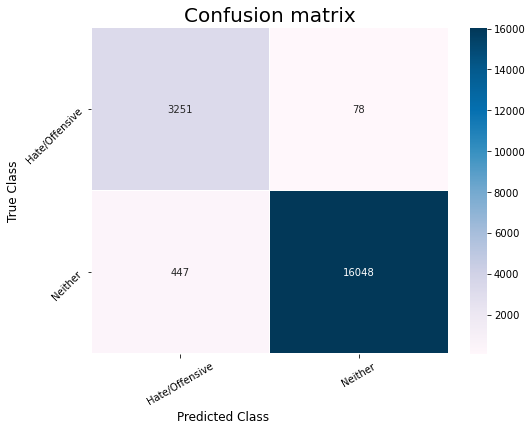

Wall time: 3.94 s


In [52]:
%%time
# performance on TRAIN
y_pred = np.argmax(model.predict(X_train), axis = 1)
y_train_n = np.argmax(y_train_bin, axis = 1)
print('Classification report:')
print(classification_report(y_train_n, y_pred))
c_matrix(y_train_n, y_pred, ["Neither", "Hate/Offensive"])

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       833
           1       0.98      0.96      0.97      4124

    accuracy                           0.95      4957
   macro avg       0.90      0.94      0.92      4957
weighted avg       0.95      0.95      0.95      4957



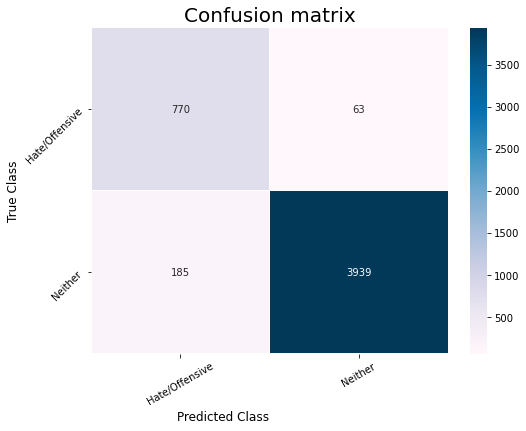

In [53]:
%%time
# performance on TEST
y_pred = np.argmax(model.predict(X_test), axis = 1)
y_test_n = np.argmax(y_test_bin, axis = 1)
print('Classification report:')
print(classification_report(y_test_n, y_pred))
c_matrix(y_test_n, y_pred, ["Neither", "Hate/Offensive"])